<a href="https://colab.research.google.com/github/jztan93/cs480student/blob/main/06/CS480_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

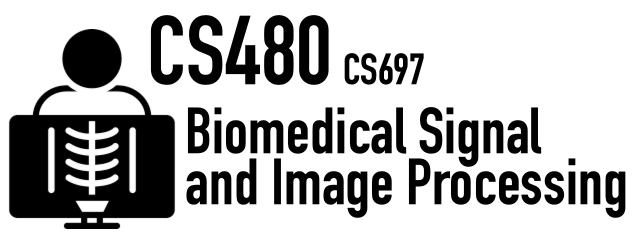
#Assignment 6

In [1]:
# In this assignment, we will train a U-Net classifer to detect mitochondria
# in electron microscopy images!

In [2]:
### IMPORTANT ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [3]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# load the unet tensorflow code
!pip install git+https://github.com/jakeret/unet.git

  Cloning https://github.com/jakeret/unet.git to /tmp/pip-req-build-sfyzngwg
  Running command git clone -q https://github.com/jakeret/unet.git /tmp/pip-req-build-sfyzngwg
  Created wheel for unet: filename=unet-0.0.post0.dev81+gf557a51-py2.py3-none-any.whl size=25658 sha256=53f1b6cbc0304baa0653b98d95695cf4a46392d9ab51d6f2ad43b6d4df9fe1d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-1okhzori/wheels/f5/38/c8/8f0a157cfd7616cc1a24811a52b9a669c0ee8fccc9f99d3cbc
Successfully built unet


In [5]:
# .. and use it!
# Note: There are a ton of U-Net implementations but this one is easier to use!
import unet

**Task 1**: Study the unet circle example and learn about mitochondria! [15 Points]

In [6]:
# The unet package allows to train a U-Net classifier with little code.
# As discussed in class, the U-Net can be used to label/segment/annotate images.

In [7]:
# TODO: Please study the Circles example 
# https://github.com/jakeret/unet/blob/master/notebooks/circles.ipynb

In [8]:
# TODO: ... and look how the (artificial) dataset is generated
# https://github.com/jakeret/unet/blob/master/src/unet/datasets/circles.py

In [9]:
# 1) Question
# TODO: Please describe what the U-Net is trained to do.
#
# TODO: YOUR ANSWER

# It is trained to recognize and segment out the individual circles from the circles data set. 

In [10]:
# 2) Question
# TODO: In circles.py, what does the following mean:
#     channels = 1
#     classes = 2
#
# TODO: YOUR ANSWER

# There is just 1 single channel in the input image (ie. it's a greyscale image)
# There are two output labels (most likely one for circle and one for non-circle)

In [11]:
# 3) Question
# TODO: What are mitochondria and what is their appearance in
# electron microscopy data?
# Hint: You can validate your answer in Task 4!
#
# TODO: YOUR ANSWER

# The mitochondria is an organelle of the cell which carries out the process of cellular respiration
# It's job is to biochemically generate ATP molecules to power the cell from glucose molecules
# For this reason, it is commonly known as the "powerhouse of the cell"
# Under the electron microscope, they look like oval or circular objects
# with wavy lines that bisect the organelle (the matrix!)

**Task 2**: Setup a datagenerator for mitochondria images! [45 Points]

In [12]:
# TODO: 
# Download https://cs480.org/data/mito.npz to your computer.
# Then, please upload mito.npz using the file panel on the left.

In [13]:
# The code below is similar to the circles.py file from Task 1.
# We follow Tensorflow conventions to design a tf.data.Dataset for training
# the U-Net.
#
# TODO: Please add four different data augmentation methods in the code block
# below. (image normalization to 0..1, horizontal data flip, vertical data flip,
# rotation by 90 degrees)
#
# Hint: https://github.com/jakeret/unet/blob/master/src/unet/datasets/oxford_iiit_pet.py#L25

In [14]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_datasets.core import DatasetInfo
from typing import Tuple, List

IMAGE_SIZE = (256, 256)
channels = 1
classes = 2

def load_data(count:int, splits:Tuple[float]=(0.7, 0.2, 0.1), **kwargs) -> List[tf.data.Dataset]:
    return [tf.data.Dataset.from_tensor_slices(_build_samples(int(split * count), **kwargs))
            for split in splits]


def _build_samples(sample_count:int, **kwargs) -> Tuple[np.array, np.array]:

    # here we load the mitochondria data
    loaded = np.load('mito.npz')
    loadedimages = loaded['arr_0'][0].copy()
    loadedmasks = loaded['arr_0'][1].copy()

    # now let's go to numpyland
    images = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
    labels = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 2))
    for i in range(sample_count):
        image, mask = loadedimages[i], loadedmasks[i]

        image = image.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1)).astype(np.float)
        mask = mask.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

        #
        # TODO: Normalize the image to 0..1
        #
        # TODO: YOUR CODE

        image = image / image.max()

        #
        # TODO: Use Tensorflow to flip the image horizontally
        #
        if tf.random.uniform(()) > 0.5:

          image = tf.image.flip_left_right(image)
          mask = tf.image.flip_left_right(mask)

        #
        # TODO: Use Tensorflow to flip the image vertically
        #
        if tf.random.uniform(()) > 0.5:

          image = tf.image.flip_up_down(image)
          mask = tf.image.flip_up_down(mask)

        #
        # TODO: Use Tensorflow to rotate the image 90 degrees
        #
        if tf.random.uniform(()) > 0.5:

          image = tf.image.rot90(image)
          mask = tf.image.rot90(mask)
    
        # augmentation done, let's store the image
        images[i] = image

        # here we split the mask to background and foreground
        fg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        fg[mask == 255] = 1
        bg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        bg[mask == 0] = 1
        
        labels[i, :, :, 0] = bg[:,:,0]
        labels[i, :, :, 1] = fg[:,:,0]

    return images, labels

**Task 3**: Let's train the U-Net! [25 Points]

In [15]:
#
# We can now create our training, validation, and testing data by calling
# our methods from Task 2.
#
train, val, test = load_data( 660, splits=(0.7, 0.2, 0.1) )

In [16]:
# 1) Question
# TODO: We have in total 660 images + 660 masks. Based on the code above,
# how many images are used for training alone?
#
# TODO: 

# 660 * 0.7 = 462 images

In [17]:
#
# Let's setup the U-Net!
#
LEARNING_RATE = 1e-3

unet_model = unet.build_model(channels=channels,
                              num_classes=classes,
                              layer_depth=5,
                              filters_root=64,
                              padding="same")

unet.finalize_model(unet_model, learning_rate=LEARNING_RATE)

In [18]:
#
# And, let's setup the trainer...
#
trainer = unet.Trainer(checkpoint_callback=False,
                       learning_rate_scheduler=unet.SchedulerType.WARMUP_LINEAR_DECAY,
                       warmup_proportion=0.1,
                       learning_rate=LEARNING_RATE)

In [19]:
#
# ...and train the U-Net for 50 epochs with a batch_size of 10!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use training and validation data.
# Hint 2: This will take roughly 30 minutes!
#
trainer.fit(unet_model,
            train,
            val, 
            epochs=50,
            batch_size=10)

Epoch 1/50
47/47 [==============================] - 58s 1s/step - loss: 0.5947 - categorical_crossentropy: 0.5947 - categorical_accuracy: 0.7314 - mean_iou: 0.3184 - dice_coefficient: 0.5840 - auc: 0.7452 - val_loss: 0.4258 - val_categorical_crossentropy: 0.4258 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.3544 - val_dice_coefficient: 0.6592 - val_auc: 0.9851
Epoch 2/50
47/47 [==============================] - 37s 787ms/step - loss: 0.2992 - categorical_crossentropy: 0.2992 - categorical_accuracy: 0.9210 - mean_iou: 0.4433 - dice_coefficient: 0.8355 - auc: 0.9391 - val_loss: 0.2796 - val_categorical_crossentropy: 0.2796 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.4164 - val_dice_coefficient: 0.7775 - val_auc: 0.9833
Epoch 3/50
47/47 [==============================] - 37s 792ms/step - loss: 0.2762 - categorical_crossentropy: 0.2762 - categorical_accuracy: 0.9210 - mean_iou: 0.4533 - dice_coefficient: 0.8563 - auc: 0.9448 - val_loss: 0.2395 - val_categorical_crossentropy

**Task 4**: Let's predict mitochondria in the testing data! [15 Points]

In [20]:
# 
# After training, let's try the U-Net on our testing data.
#
# The code below displays the first 10 input images, the original masks by experts, 
# and the predicted masks from the U-Net.

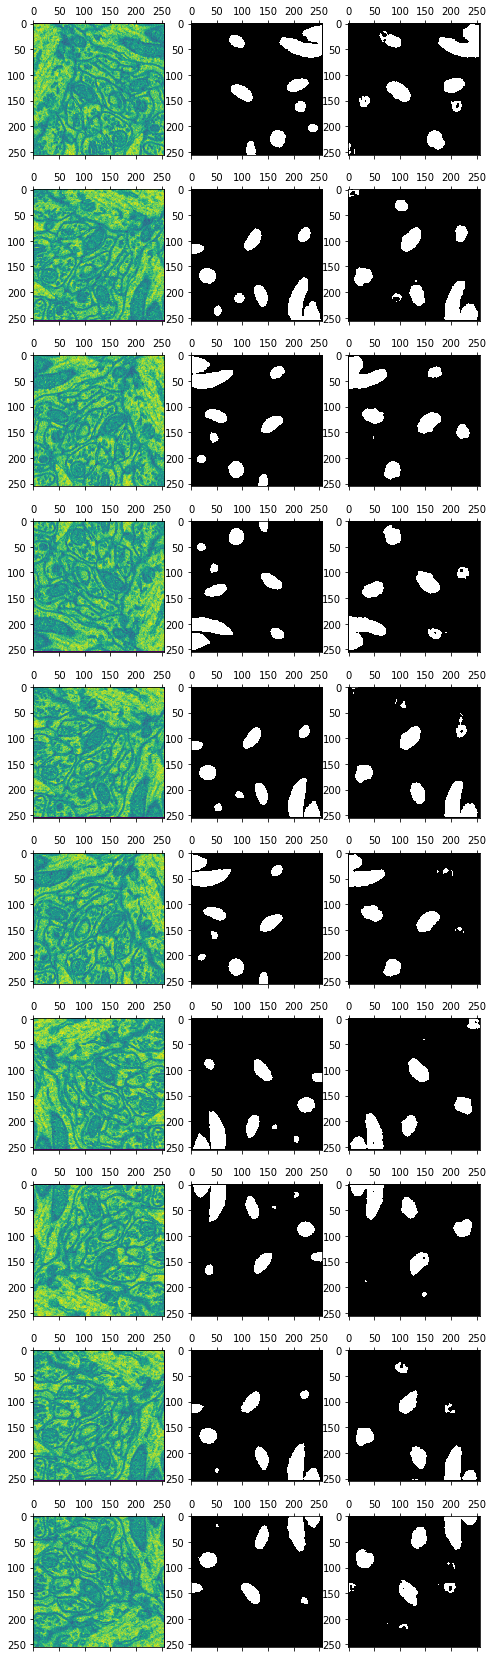

In [21]:
rows = 10
fig, axs = plt.subplots(rows, 3, figsize=(8, 30))
for ax, (image, label) in zip(axs, test.take(rows).batch(1)):
  
  prediction = unet_model.predict(image)
  ax[0].matshow(image[0, :, :, 0])
  ax[1].matshow(label[0, :, :, 1], cmap="gray")
  ax[2].matshow(prediction[0].argmax(axis=-1), cmap="gray")

In [22]:
# 1) Question
# TODO: Why do we use the prediction[0].argmax(axis=-1) command
# to display the prediction?
# 
# TODO: 

print(prediction[0].shape)

# The shape of prediction[0] is 256 x 256 x 2
# By passing an axis of -1 into argmax, we will lose the very last axis
# And we will isntead get a 2D array of shape 256 x 256
# With values ranging from 0-1
# This is exactly what we need in order to display the threshold of the mitochondria


(256, 256, 2)


In [23]:
prediction[0].argmax(axis=-1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [24]:
# 2) Question
# TODO: Is the quality of the segmentation good and how could we improve it?
# Hint: Think along the lines of some traditional image processing rather than
# increasing the training data size.
#
# TODO: YOUR ANSWER


I was actually very surprised with the outcome and I think it did an excellent job, especially for being an algorithm that is fully automatic. The loss started out around 61%, but after 50 epochs, it radually went down to about 7%. While I think more data and more epochs/training would certainly help improve the neural network, it did segmented out some sections that weren't supposed to be segmented. 
<br><br>
I think one of the things we can do is first denoise the image and apply some thresholding to clean up the image before we pass it into neural network. In addition, I think the outcomes would improve even more if we give the neural network some sort of template as to how a mitochondria would look like at different orientations. Such a template would have to be general enough so that the neural network gets a sense of what a mitochondria looks like and its general shape so that it can pick them out from a source image. 

**Bonus**: Compare against the state-of-the-art literature! [33 Points]

In [25]:
#
# The following paper also uses a 2D U-Net to detect mitochondria:
# 
# https://danielhaehn.com/papers/?casser2020fast
#

In [26]:
# 1) Question
#
# TODO: How many learnable parameters does your trained unet_model have?
# Hint: You can use TF's Model Summary function to answer this.
#

In [27]:
# TODO: YOUR CODE

unet_model.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_block (ConvBlock)          (None, None, None, 6 37568       inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 6 0           conv_block[0][0]                 
__________________________________________________________________________________________________
conv_block_1 (ConvBlock)        (None, None, None, 1 221440      max_pooling2d[0][0]              
_______________________________________________________________________________________________

In [28]:
# There are 31,030,658 learnable parameters! 

In [29]:
# 2) Question
#
# TODO: How many parameters do Casser et al. use?
#

In [30]:
# TODO: YOUR ANSWER

Encoder: 1,178,480 <br>
Decoder: 780,053 <br>
**Total: 1,958,533**

In [31]:
# 3) Question
#
# TODO: How did Casser et al. reduce the parameters?
#

In [32]:
# TODO: YOUR ANSWER

Some ways in which Casser et. al reduced parameters: 
*   The number of convolutional filters were reduced throughout the network. 
*   Transpose convolutions in the decoder were replaced with light-weight bilinear upsampling layers, which requires no parameters.
*   Center-cropping from the original U-Net were replaced with padding



In [33]:
# 4) Question
#
# TODO: Why did Casser et al. reduce the parameters?
#

In [34]:
# TODO: YOUR ANSWER

So that the neural network can run very quickly and operate at a faster processing speed than the acquisition speed of a scanning electron microscope. This allows for the detection of mitochondria in real-time as the scans are coming off the microscope!

In [35]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#